<h1><div align="center">PROJECT 2 - SENTIMENT ANALYSIS - NEURAL NETWORKS <br>
CHRISTOS GEORGIOS FOUKANELIS - 1115201900204<h1>

In [658]:
import torch
import numpy as np
import pickle
import nltk
from nltk.corpus import stopwords
nltk.download('vader_lexicon')
nltk.download('stopwords') 
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
import re
import time
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
import matplotlib.patches as mpatches
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import torch.nn as nn
import optuna
import warnings
import torch.optim as optim
warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/fouk/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/fouk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [751]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

<h2>PREPROCESSING<h2>
___________________________________________________________________________________________________________________

<h3>DATA CLEANING<h3>

In [659]:
cachedStopWords = stopwords.words("english")

def remove_links(x):
    return re.sub(r"http\S+", "", x)

def remove_punctuation(x):
    return re.sub(r'[^\w\s]', '', x)

def lowercase(x):
    return x.lower()

def remove_stopwords(x):
    return ' '.join([word for word in x.split() if word not in cachedStopWords])

def remove_html(x):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', x)

def sentiment_label(x):
    if x >= 7.0:
        return 1
    elif x <= 4.0:
        return 0
    
def word_count(x):
    return len(x.split(' '))

CREATING THE DATAFRAME THAT REPRESENTS THE DATA

In [116]:
data = pd.read_csv('imdb-reviews.csv',sep = '\t', engine = 'python')

In [117]:
data.head()

,url,rating,review
0,http://www.imdb.com/title/tt0120623/usercomments,10.0,I thought this was a quiet good movie. It was ...
1,http://www.imdb.com/title/tt0043117/usercomments,9.0,Wagon Master is a very unique film amongst Joh...
2,http://www.imdb.com/title/tt0043117/usercomments,10.0,This film has to be as near to perfect a film ...
3,http://www.imdb.com/title/tt0835204/usercomments,4.0,I gave this 4 stars because it has a lot of in...
4,http://www.imdb.com/title/tt0499603/usercomments,10.0,This movie is really genuine and random. It's ...


In [118]:
# clean the data
data['review'] = data['review'].apply(remove_links)
data['review'] = data['review'].apply(lowercase)
data['review'] = data['review'].apply(remove_punctuation)
data['review'] = data['review'].apply(remove_stopwords)
data['review'] = data['review'].apply(remove_html)
data['rating'] = data['rating'].apply(sentiment_label)
data.drop(data[data['rating'] == None].index, inplace = True)

In [11]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-12-15 11:56:07--  http://nlp.stanford.edu/data/glove.6B.zip
Εύρεση του nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... συνδέθηκε.
Η αίτηση για HTTP στάλθηκε, αναμονή απάντησης... 302 Found
Τοποθεσία: https://nlp.stanford.edu/data/glove.6B.zip [ακολουθεί]
--2022-12-15 11:56:08--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... συνδέθηκε.
Η αίτηση για HTTP στάλθηκε, αναμονή απάντησης... 301 Moved Permanently
Τοποθεσία: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [ακολουθεί]
--2022-12-15 11:56:08--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Εύρεση του downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... συνδέθηκε.
Η αίτηση για HTTP στάλθηκε, αναμονή απάντησης... 200 OK
Μήκος: 862182613 (822M) [application/zip]
S

In [12]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


<h3>WORD EMBEDDINGS CREATION<h3>

In [366]:
glove_input_file = 'glove.6B.200d.txt'
w2v_output_file = 'glv_with_w2v_format.txt'

glove2word2vec(glove_input_file, w2v_output_file)

(400000, 200)

In [367]:
with open(w2v_output_file, 'r') as infile:
    w2v = infile.read().splitlines()

w2v_dict = {
    'word': [],
    'vector': []
}

for word_vector_pair in w2v[1:22]:
    word_vector_pair = word_vector_pair.split()
    word = word_vector_pair[0]
    vector = word_vector_pair[1:]
    w2v_dict['word'].append(word)
    w2v_dict['vector'].append(vector)

w2v_df = pd.DataFrame.from_dict(w2v_dict)


,word,vector
0,the,"[-0.071549, 0.093459, 0.023738, -0.090339, 0.0..."
1,",","[0.17651, 0.29208, -0.0020768, -0.37523, 0.004..."
2,.,"[0.12289, 0.58037, -0.069635, -0.50288, 0.1050..."
3,of,"[0.052924, 0.25427, 0.31353, -0.35613, 0.02962..."
4,to,"[0.57346, 0.5417, -0.23477, -0.3624, 0.4037, 0..."
5,and,"[0.20327, 0.47348, 0.050877, 0.002103, 0.06054..."
6,in,"[-0.10272, 0.3041, -0.13577, -0.27979, -0.4092..."
7,a,"[0.24169, -0.34534, -0.22307, -1.2907, 0.25285..."
8,"""","[0.0010318, 0.31201, -0.59768, -0.12583, -0.27..."
9,'s,"[-0.0059614, 0.45148, 0.0045495, 0.020727, 0.5..."


In [368]:
with open(w2v_output_file, 'r') as infile:
    w2v = infile.read().splitlines()

w2v_dict = {}

for word_vector_pair in w2v:
    word_vector_pair = word_vector_pair.split()
    word = word_vector_pair[0]
    vector = word_vector_pair[1:]
    w2v_dict[word] = vector

In [369]:
data.dropna(axis=0,how='any',inplace=True)

In [370]:
# creating vector for each review based on mean of word vectors
data['review_embedding'] = data['review'].apply(lambda text: np.mean([np.array(w2v_dict[word],dtype=float) for word in text.split() if word in w2v_dict.keys()],axis=0))

<h3>TRAIN DATASET SPLIT<h3>

In [371]:
model_input, expected_output = data['review_embedding'].tolist(), data['rating'].tolist()
expected_output = np.array(expected_output)
expected_output = np.reshape(expected_output, (expected_output.shape[0],1))

input_train, input_validation, output_train, output_validation = train_test_split(
                    model_input, expected_output, test_size=0.20, random_state=1)

In [372]:
data.head(5)

,url,rating,review,review_embedding
0,http://www.imdb.com/title/tt0120623/usercomments,1,thought quiet good movie fun watch liked best ...,"[0.36770058333333333, 0.13849366666666665, -0...."
1,http://www.imdb.com/title/tt0043117/usercomments,1,wagon master unique film amongst john fords wo...,"[0.018611560500000002, 0.06392013699999999, -0..."
2,http://www.imdb.com/title/tt0043117/usercomments,1,film near perfect film john ford made film mag...,"[0.0753184424528302, 0.029983174528301886, -0...."
3,http://www.imdb.com/title/tt0835204/usercomments,0,gave 4 stars lot interesting themes many alrea...,"[0.16934218367346945, 0.18764791734693875, -0...."
4,http://www.imdb.com/title/tt0499603/usercomments,1,movie really genuine random really hard find m...,"[0.25914649504950493, 0.18944024653465336, -0...."


In [373]:
x_train = torch.tensor(input_train, dtype=torch.float)
x_validation = torch.tensor(input_validation, dtype=torch.float)

In [374]:
y_train = torch.tensor(output_train, dtype=torch.float)
y_validation = torch.tensor(output_validation, dtype=torch.float)

In [375]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_validation shape: {x_validation.shape}")
print(f"y_validation shape: {y_validation.shape}")

xt shape: torch.Size([36006, 200])
yt shape: torch.Size([36006, 1])
xv shape: torch.Size([9002, 200])
yv shape: torch.Size([9002, 1])


<h3>SUPPORTING CODE FOR HYPERPARAMETER TUNING - MODEL ARCHITECTURE EXPIRIMENTATION<h3>

In [660]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round((y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [667]:
# search space
def objective(trial):
    
    params = {
              'learning_rate': trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3]),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              'n_unit': trial.suggest_categorical("n_unit", [64, 128]),
              'epochs': trial.suggest_categorical("epochs", [20, 50, 80, 100]),
              'batch_size': trial.suggest_categorical("batch_size", [16, 32, 64]),
              'loss_funct': trial.suggest_categorical("loss_funct", ["MSELoss", "BCELoss"]),
              'dropout': trial.suggest_categorical("dropout", [True, False]),
              'activationFunction': trial.suggest_categorical("activationFunction", ["LeakyReLU", "ReLU"])
             }
    
    model = build_model(params,trial)
    
    accuracy = train_and_evaluate(params,model,trial)
    
    return accuracy

In [672]:
def build_model(params,trial):
    
    # number of layers in network
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []
    # Define layer sizes
    in_features = x_train.shape[1]
    #in_features = 200
    nodes =  params['n_unit']
    out_features = nodes
    D_out = 1
    # flag to add dropout layer
    withDropout = params['dropout']
    activationFunction = getattr(nn, params['activationFunction'])() 

    for i in range(n_layers):
        
        layers.append(nn.Linear(in_features, out_features))
        layers.append(activationFunction)
        if(withDropout):
            layers.append(nn.Dropout(p=0.5))
        
        
        # next layer nodes ar half of previous layer
        in_features = out_features
        out_features = out_features // 2  
        
    # output layer
    layers.append(nn.Linear(in_features,D_out))
    layers.append(nn.Sigmoid())       

    #Initialise model
    
    return nn.Sequential(*layers)

In [669]:
def train_and_evaluate(params, model, trial):
    
    #Define Hyperparameters
    learning_rate = params['learning_rate']
    epochs = params['epochs']
    batch_size = params['batch_size']
    
    train = torch.utils.data.TensorDataset(x_train, y_train)
    evaluate = torch.utils.data.TensorDataset(x_validation, y_validation)
    
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    validate_dataloader = torch.utils.data.DataLoader(evaluate, batch_size=batch_size)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    # add loss and optimizer
    loss_func = getattr(nn, params['loss_funct'])()
    optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr = params['learning_rate'])
    
    
    for epoch in range(epochs):
      
        batch_losses_train = []
        batch_acc_train = []

        model.train()
        for x_batch, y_batch in train_dataloader:

            y_pred = model(x_batch)

            loss = loss_func(y_pred, y_batch)
            acc = binary_acc(y_pred, y_batch)
            batch_losses_train.append(loss.item())
            batch_acc_train.append(acc)

            #Delete previously stored gradients
            optimizer.zero_grad()
            #Perform backpropagation starting from the loss calculated in this epoch
            loss.backward()
            #Update model's weights based on the gradients calculated during backprop
            optimizer.step()

        
        batch_losses_val = []
        batch_acc_val = []
        
        model.eval()
        with torch.no_grad():
        
            for val_input, val_label in validate_dataloader:

                y_pred = model(val_input)

                loss = loss_func(y_pred, val_label)
                acc = binary_acc(y_pred, val_label)
                batch_losses_val.append(loss.item())
                batch_acc_val.append(acc)
                
        accuracy = sum(batch_acc_val)/len(validate_dataloader)

            
    return accuracy                  

<h3>EXPLORING DIFFERENT MODELS<h3>

In [673]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=50)

[I 2022-12-22 01:22:28,414] A new study created in memory with name: no-name-d4c21aa4-1c39-46bc-b18d-7d97e311205d
[I 2022-12-22 01:22:57,553] Trial 0 finished with value: 81.97872161865234 and parameters: {'learning_rate': 1e-05, 'optimizer': 'RMSprop', 'n_unit': 128, 'epochs': 20, 'batch_size': 32, 'loss_funct': 'BCELoss', 'dropout': False, 'activationFunction': 'ReLU', 'n_layers': 3}. Best is trial 0 with value: 81.97872161865234.
[I 2022-12-22 01:25:19,415] Trial 1 finished with value: 82.26241302490234 and parameters: {'learning_rate': 0.0001, 'optimizer': 'RMSprop', 'n_unit': 128, 'epochs': 100, 'batch_size': 32, 'loss_funct': 'BCELoss', 'dropout': False, 'activationFunction': 'ReLU', 'n_layers': 3}. Best is trial 1 with value: 82.26241302490234.
[I 2022-12-22 01:27:21,998] Trial 2 finished with value: 82.58081817626953 and parameters: {'learning_rate': 1e-05, 'optimizer': 'Adam', 'n_unit': 128, 'epochs': 50, 'batch_size': 16, 'loss_funct': 'BCELoss', 'dropout': False, 'activation

[I 2022-12-22 02:30:05,248] Trial 24 finished with value: 83.45390319824219 and parameters: {'learning_rate': 0.001, 'optimizer': 'Adam', 'n_unit': 128, 'epochs': 80, 'batch_size': 64, 'loss_funct': 'BCELoss', 'dropout': True, 'activationFunction': 'LeakyReLU', 'n_layers': 2}. Best is trial 18 with value: 84.1865005493164.
[I 2022-12-22 02:33:41,897] Trial 25 finished with value: 82.9769058227539 and parameters: {'learning_rate': 0.001, 'optimizer': 'RMSprop', 'n_unit': 128, 'epochs': 80, 'batch_size': 16, 'loss_funct': 'BCELoss', 'dropout': True, 'activationFunction': 'LeakyReLU', 'n_layers': 3}. Best is trial 18 with value: 84.1865005493164.
[I 2022-12-22 02:35:13,178] Trial 26 finished with value: 83.87943267822266 and parameters: {'learning_rate': 0.001, 'optimizer': 'Adam', 'n_unit': 128, 'epochs': 80, 'batch_size': 64, 'loss_funct': 'BCELoss', 'dropout': True, 'activationFunction': 'LeakyReLU', 'n_layers': 3}. Best is trial 18 with value: 84.1865005493164.
[I 2022-12-22 02:37:52,

[I 2022-12-22 03:37:41,610] Trial 49 finished with value: 83.82948303222656 and parameters: {'learning_rate': 0.0001, 'optimizer': 'RMSprop', 'n_unit': 64, 'epochs': 80, 'batch_size': 16, 'loss_funct': 'MSELoss', 'dropout': True, 'activationFunction': 'LeakyReLU', 'n_layers': 3}. Best is trial 18 with value: 84.1865005493164.


In [758]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

learning_rate: 0.001
optimizer: Adam
n_unit: 128
epochs: 80
batch_size: 16
loss_funct: BCELoss
dropout: True
activationFunction: LeakyReLU
n_layers: 2


In [731]:
dataset = torch.utils.data.TensorDataset(x_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
val_set = torch.utils.data.TensorDataset(x_validation, y_validation)
validationloader = torch.utils.data.DataLoader(val_set, batch_size=1)

In [732]:
def build_model(params):
    
    n_layers = params['n_layers']
    layers = []
    in_features = x_train.shape[1]
    #in_features = 200
    nodes = params['n_unit']
    out_features = nodes
    D_out = 1
    withDropout = params['dropout']
    activationFunction = getattr(nn, params['activationFunction'])() 

    for i in range(n_layers):
        
        layers.append(nn.Linear(in_features, out_features))
        layers.append(activationFunction)
        if(withDropout):
            layers.append(nn.Dropout(p=0.5))
        
        
        in_features = out_features
        out_features = out_features // 2
        
        
    layers.append(nn.Linear(in_features,D_out))
    layers.append(nn.Sigmoid())
        

    #Initialise model
    
    return nn.Sequential(*layers)

In [733]:
def train_and_evaluate_model(params, model):
    
    #Define Hyperparameters
    learning_rate = params['learning_rate']
    epochs = params['epochs']
    batch_size = params['batch_size']
    
    train = torch.utils.data.TensorDataset(x_train, y_train)
    evaluate = torch.utils.data.TensorDataset(x_validation, y_validation)
    
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    validate_dataloader = torch.utils.data.DataLoader(evaluate, batch_size=batch_size)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    # add loss and optimizer
    loss_func = getattr(nn, params['loss_funct'])()
    optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr = params['learning_rate'])
    
        
    epoch_loss_train = []
    epoch_acc_train = []
    epoch_loss_val = []
    epoch_acc_val = []
    
    for epoch in range(epochs):
      
        batch_losses_train = []
        batch_acc_train = []

        for x_batch, y_batch in train_dataloader:

            y_pred = model(x_batch)

            loss = loss_func(y_pred, y_batch)
            acc = binary_acc(y_pred, y_batch)
            batch_losses_train.append(loss.item())
            batch_acc_train.append(acc)

            #Delete previously stored gradients
            optimizer.zero_grad()
            #Perform backpropagation starting from the loss calculated in this epoch
            loss.backward()
            #Update model's weights based on the gradients calculated during backprop
            optimizer.step()

        print(f"Epoch {epoch:3}: | Loss = {sum(batch_losses_train)/len(train_dataloader):.5f} | Acc = {sum(batch_acc_train)/len(train_dataloader):.5f}")
        epoch_loss_train.append(sum(batch_losses_train)/len(train_dataloader))
        epoch_acc_train.append(sum(batch_acc_train)/len(train_dataloader))
        
        batch_losses_val = []
        batch_acc_val = []
        
        with torch.no_grad():
                                
            for val_input, val_label in validate_dataloader:

                y_pred = model(val_input)

                loss = loss_func(y_pred, val_label)
                acc = binary_acc(y_pred, val_label)
                batch_losses_val.append(loss.item())
                batch_acc_val.append(acc)
                
        accuracy = sum(batch_acc_val)/len(validate_dataloader)
        epoch_loss_val.append(sum(batch_losses_val)/len(validate_dataloader))
        epoch_acc_val.append(sum(batch_acc_val)/len(validate_dataloader))
            
    return epoch_loss_train, epoch_acc_train, epoch_loss_val, epoch_acc_val

In [781]:
def model_eval(model,params,test_dataloader, y_validation):
    
    y_validation = y_validation.squeeze().tolist()
    
    epoch_loss_train, epoch_acc_train, epoch_loss_val, epoch_acc_val = train_and_evaluate_model(params, model) 
    
    
    y_pred_list = []
    y_probab_list = []
    model.eval()
    with torch.no_grad():
        for X_batch, y_label in test_dataloader:
            y_test_pred = model(X_batch)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.numpy())
            y_probab_list.append(y_test_pred.numpy())

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_probab_list = [a.squeeze().tolist() for a in y_probab_list]
    
    
    print(len(y_validation),len(y_pred_list))
    
    print("--------------------------------------------")
    print("Model confusion matrix: \n",confusion_matrix(y_validation, y_pred_list))
    print("--------------------------------------------")
    print("Model classification report: \n",classification_report(y_validation, y_pred_list))
    print("--------------------------------------------")
    print("Model accuracy: ",metrics.accuracy_score(y_validation, y_pred_list))
    print("--------------------------------------------")

    plt.plot(epoch_acc_train,'-o')
    plt.plot(epoch_acc_val,'-o')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Train', 'Validation'])
    plt.title('Train vs Validation Accuracy')
    plt.show()

    plt.plot(epoch_loss_train,'-o')
    plt.plot(epoch_loss_val,'-o')
    plt.xlabel('epoch')
    plt.ylabel('losses')
    plt.legend(['Train', 'Validation'])
    plt.title('Train vs Validation Losses')
    plt.show()
    
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_validation, y_probab_list)
    print("--------------------------------------------")
    print('roc_auc_score for model: ', roc_auc_score(y_validation, y_probab_list))
    print("--------------------------------------------")
    plt.title('Receiver Operating Characteristic - Neural Network')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return model

In [791]:
def model_test(model,testloader, y_test):
    
    y_test = y_test.squeeze().tolist()
    
    y_pred_list = []
    y_probab_list = []
    model.eval()
    with torch.no_grad():
        for X_batch, y_label in testloader:
            y_test_pred = model(X_batch)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.numpy())
            y_probab_list.append(y_test_pred.numpy())

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_probab_list = [a.squeeze().tolist() for a in y_probab_list]
    
        
    print("--------------------------------------------")
    print("Model confusion matrix: \n",confusion_matrix(y_test, y_pred_list))
    print("--------------------------------------------")
    print("Model classification report: \n",classification_report(y_test, y_pred_list))
    print("--------------------------------------------")
    print("Model accuracy: ",metrics.accuracy_score(y_test, y_pred_list))
    print("--------------------------------------------")

    
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_probab_list)
    print("--------------------------------------------")
    print('roc_auc_score for model: ', roc_auc_score(y_test, y_probab_list))
    print("--------------------------------------------")
    plt.title('Receiver Operating Characteristic - Neural Network')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

<h3>OPTIMAL MODEL TRAINING AND EVALUATION<h3>

Epoch   0: | Loss = 0.46283 | Acc = 78.31631
Epoch   1: | Loss = 0.41744 | Acc = 81.21635
Epoch   2: | Loss = 0.41169 | Acc = 81.76366
Epoch   3: | Loss = 0.40669 | Acc = 82.18347
Epoch   4: | Loss = 0.40222 | Acc = 82.23323
Epoch   5: | Loss = 0.40023 | Acc = 82.27055
Epoch   6: | Loss = 0.39776 | Acc = 82.64949
Epoch   7: | Loss = 0.39581 | Acc = 82.32030
Epoch   8: | Loss = 0.39241 | Acc = 82.75388
Epoch   9: | Loss = 0.39166 | Acc = 82.77876
Epoch  10: | Loss = 0.38805 | Acc = 82.97690
Epoch  11: | Loss = 0.38672 | Acc = 83.09151
Epoch  12: | Loss = 0.38578 | Acc = 83.13860
Epoch  13: | Loss = 0.38487 | Acc = 83.21191
Epoch  14: | Loss = 0.38137 | Acc = 83.49622
Epoch  15: | Loss = 0.37956 | Acc = 83.49178
Epoch  16: | Loss = 0.37886 | Acc = 83.46024
Epoch  17: | Loss = 0.37754 | Acc = 83.79298
Epoch  18: | Loss = 0.37713 | Acc = 83.52288
Epoch  19: | Loss = 0.37441 | Acc = 83.51977
Epoch  20: | Loss = 0.37311 | Acc = 83.90315
Epoch  21: | Loss = 0.37322 | Acc = 83.72634
Epoch  22:

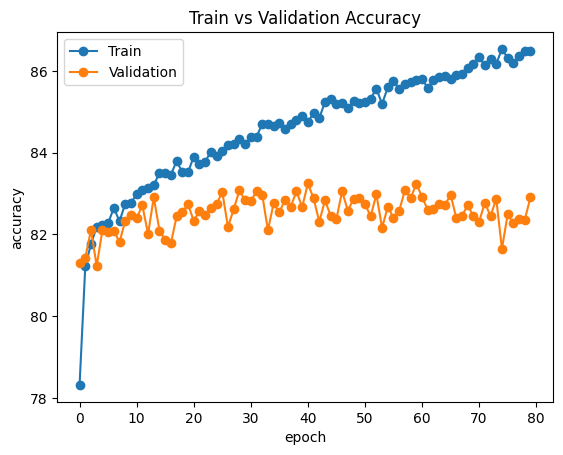

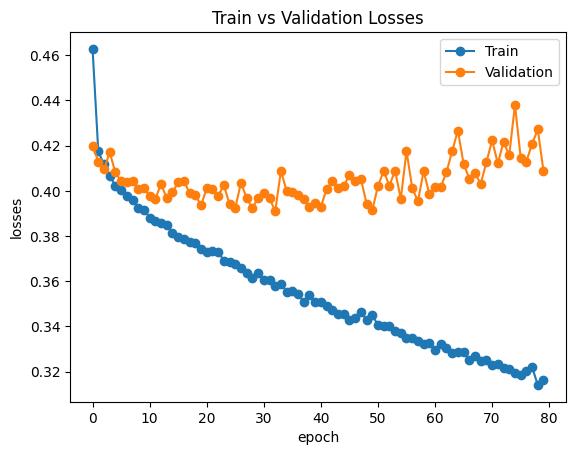

--------------------------------------------
roc_auc_score for model:  0.9157305029093358
--------------------------------------------


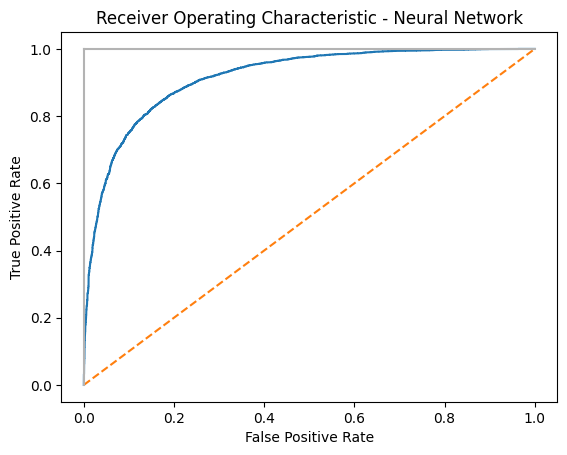

In [763]:
model_eval(build_model(best_trial.params),best_trial.params,validationloader,y_validation)

ALTERNATIVE NETWORK ARCHITECTURES

In [752]:
model_params1 = {
    'learning_rate': 0.0001,
    'optimizer': "Adam",
    'n_unit': 128,
    'epochs': 80,
    'batch_size': 64,
    'loss_funct': "BCELoss",
    'dropout': False,
    'activationFunction': "LeakyReLU",
    'n_layers': 1
}

model_params2 = {
    'learning_rate': 0.0001,
    'optimizer': "Adam",
    'n_unit': 128,
    'epochs': 80,
    'batch_size': 16,
    'loss_funct': "BCELoss",
    'dropout':    True,
    'activationFunction': "ReLU",
    'n_layers': 2  
}

model_params3 = {
    'learning_rate': 0.001,
    'optimizer': "RMSprop",
    'n_unit': 64,
    'epochs': 60,
    'batch_size': 64,
    'loss_funct': "MSELoss",
    'dropout':    True,
    'activationFunction': "ReLU",
    'n_layers': 1 
}

EXAMPLE 1

Epoch   0: | Loss = 0.63249 | Acc = 70.72646
Epoch   1: | Loss = 0.51629 | Acc = 76.81172
Epoch   2: | Loss = 0.46423 | Acc = 79.09946
Epoch   3: | Loss = 0.43832 | Acc = 80.28419
Epoch   4: | Loss = 0.42341 | Acc = 81.04618
Epoch   5: | Loss = 0.41401 | Acc = 81.50444
Epoch   6: | Loss = 0.40753 | Acc = 81.79041
Epoch   7: | Loss = 0.40303 | Acc = 82.08170
Epoch   8: | Loss = 0.39988 | Acc = 82.20248
Epoch   9: | Loss = 0.39766 | Acc = 82.28064
Epoch  10: | Loss = 0.39554 | Acc = 82.44760
Epoch  11: | Loss = 0.39414 | Acc = 82.36768
Epoch  12: | Loss = 0.39315 | Acc = 82.53286
Epoch  13: | Loss = 0.39172 | Acc = 82.51154
Epoch  14: | Loss = 0.39075 | Acc = 82.56306
Epoch  15: | Loss = 0.38969 | Acc = 82.71048
Epoch  16: | Loss = 0.38901 | Acc = 82.68916
Epoch  17: | Loss = 0.38837 | Acc = 82.65364
Epoch  18: | Loss = 0.38757 | Acc = 82.69804
Epoch  19: | Loss = 0.38694 | Acc = 82.78508
Epoch  20: | Loss = 0.38615 | Acc = 82.80640
Epoch  21: | Loss = 0.38551 | Acc = 82.79041
Epoch  22:

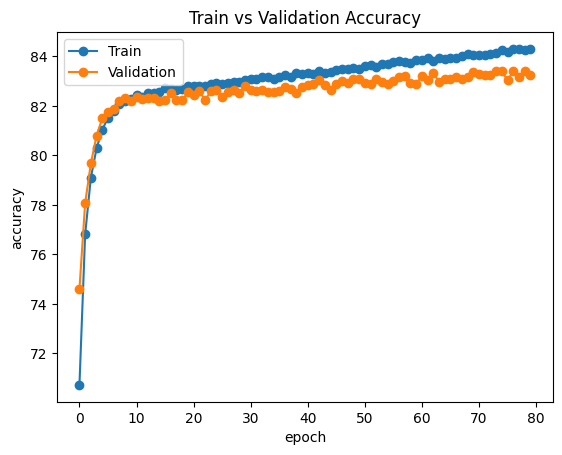

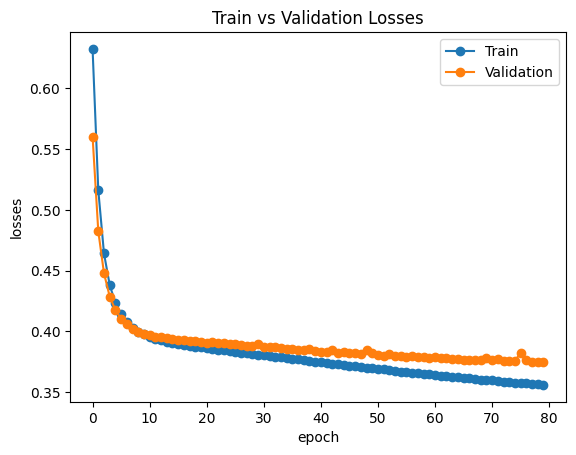

--------------------------------------------
roc_auc_score for model:  0.9129133734670949
--------------------------------------------


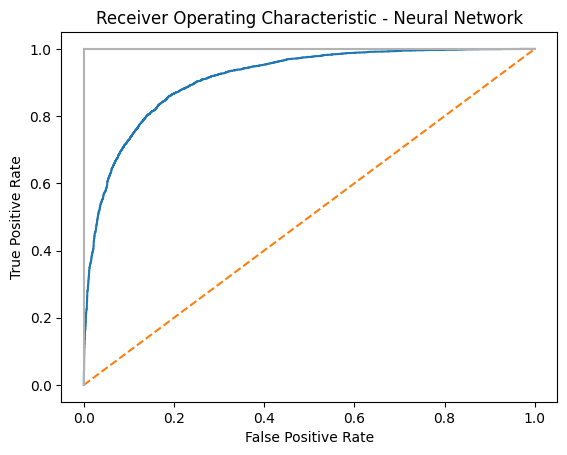

In [784]:
optimal_model = build_model(model_params1)
optimal_model = model_eval(optimal_model, model_params1, validationloader, y_validation)
model_scripted = torch.jit.script(optimal_model)
model_scripted.save('model_scripted.pt')

EXAMPLE 2

Epoch   0: | Loss = 0.57728 | Acc = 70.54731
Epoch   1: | Loss = 0.45194 | Acc = 79.43225
Epoch   2: | Loss = 0.42468 | Acc = 80.89871
Epoch   3: | Loss = 0.41487 | Acc = 81.58952
Epoch   4: | Loss = 0.40940 | Acc = 81.98934
Epoch   5: | Loss = 0.40533 | Acc = 82.29053
Epoch   6: | Loss = 0.40024 | Acc = 82.46824
Epoch   7: | Loss = 0.39782 | Acc = 82.59929
Epoch   8: | Loss = 0.39533 | Acc = 82.71257
Epoch   9: | Loss = 0.39280 | Acc = 82.75833
Epoch  10: | Loss = 0.39152 | Acc = 82.84052
Epoch  11: | Loss = 0.38980 | Acc = 83.04131
Epoch  12: | Loss = 0.38953 | Acc = 83.08663
Epoch  13: | Loss = 0.38693 | Acc = 83.25278
Epoch  14: | Loss = 0.38529 | Acc = 83.19102
Epoch  15: | Loss = 0.38470 | Acc = 83.29231
Epoch  16: | Loss = 0.38348 | Acc = 83.42648
Epoch  17: | Loss = 0.38005 | Acc = 83.51843
Epoch  18: | Loss = 0.37987 | Acc = 83.52021
Epoch  19: | Loss = 0.38098 | Acc = 83.68015
Epoch  20: | Loss = 0.37670 | Acc = 83.91426
Epoch  21: | Loss = 0.37661 | Acc = 83.95957
Epoch  22:

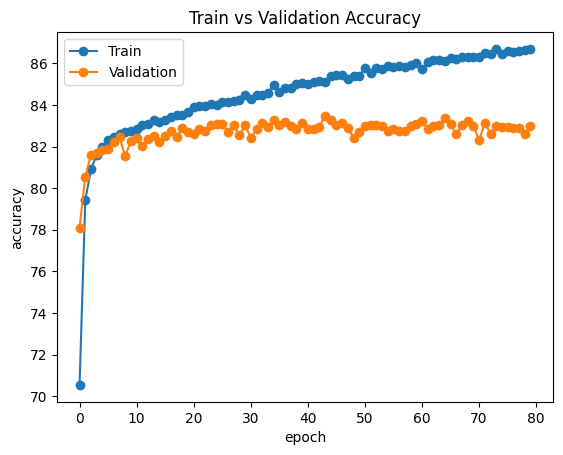

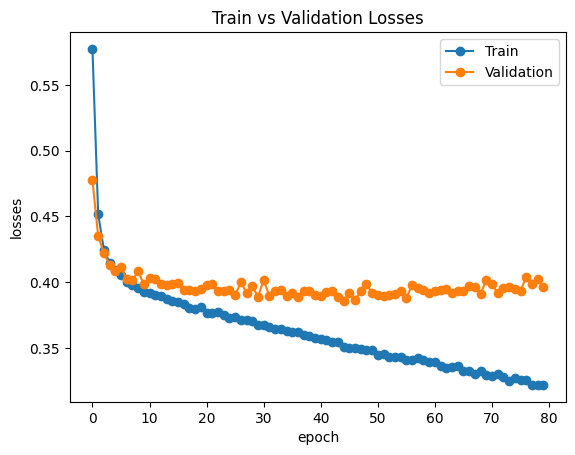

--------------------------------------------
roc_auc_score for model:  0.9178348599036869
--------------------------------------------


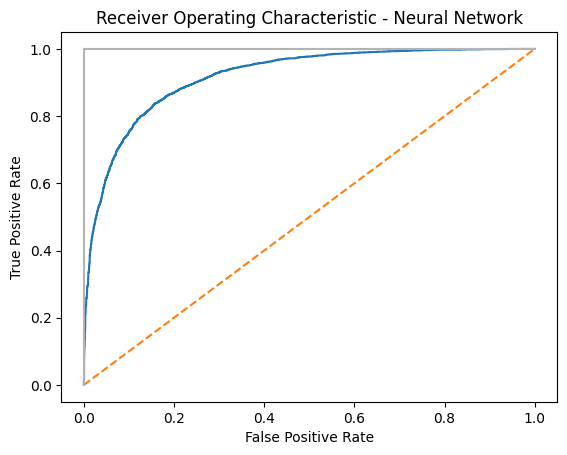

In [765]:
model_eval(build_model(model_params2),model_params2,validationloader,y_validation)

EXAMPLE 3

Epoch   0: | Loss = 0.16544 | Acc = 76.60213
Epoch   1: | Loss = 0.13727 | Acc = 80.63232
Epoch   2: | Loss = 0.13156 | Acc = 81.62344
Epoch   3: | Loss = 0.12949 | Acc = 81.92007
Epoch   4: | Loss = 0.12747 | Acc = 82.29130
Epoch   5: | Loss = 0.12669 | Acc = 82.36234
Epoch   6: | Loss = 0.12643 | Acc = 82.36590
Epoch   7: | Loss = 0.12517 | Acc = 82.56660
Epoch   8: | Loss = 0.12412 | Acc = 82.66430
Epoch   9: | Loss = 0.12412 | Acc = 82.74068
Epoch  10: | Loss = 0.12343 | Acc = 82.80462
Epoch  11: | Loss = 0.12290 | Acc = 82.96803
Epoch  12: | Loss = 0.12258 | Acc = 82.92184
Epoch  13: | Loss = 0.12227 | Acc = 83.04440
Epoch  14: | Loss = 0.12249 | Acc = 82.91830
Epoch  15: | Loss = 0.12180 | Acc = 83.12256
Epoch  16: | Loss = 0.12122 | Acc = 83.19894
Epoch  17: | Loss = 0.12106 | Acc = 83.41740
Epoch  18: | Loss = 0.12098 | Acc = 83.26998
Epoch  19: | Loss = 0.12027 | Acc = 83.53108
Epoch  20: | Loss = 0.12040 | Acc = 83.39432
Epoch  21: | Loss = 0.11970 | Acc = 83.42628
Epoch  22:

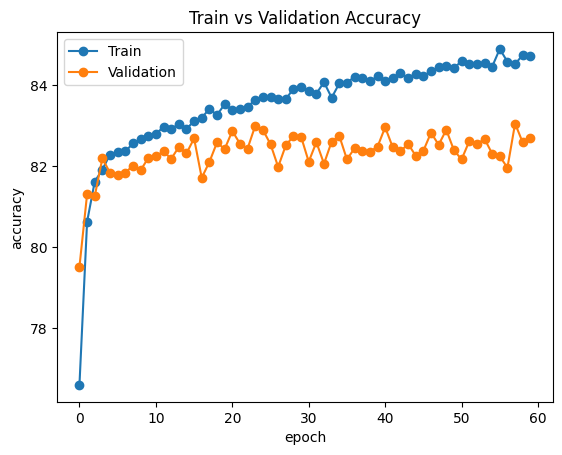

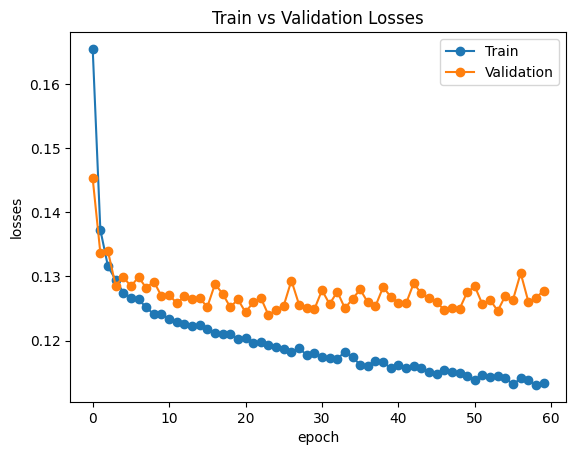

--------------------------------------------
roc_auc_score for model:  0.9116557052399635
--------------------------------------------


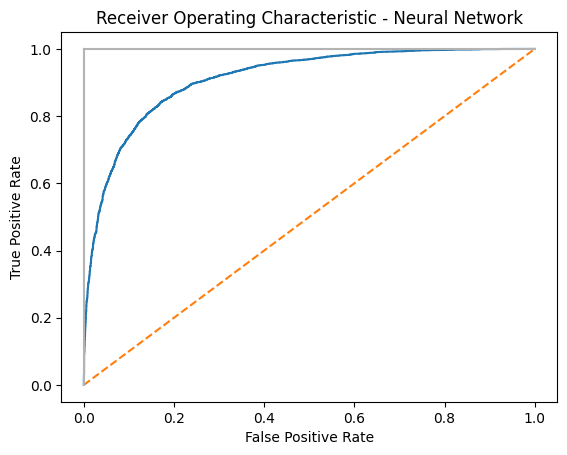

In [766]:
model_eval(build_model(model_params3),model_params3,validationloader,y_validation)

In [ ]:
# ***********MODEL-TESTING-INSERST-CSV-TEST-FILE-HERE***********

test_model = torch.jit.load('model_scripted.pt')

test_data = pd.read_csv('imdb-reviews.csv',sep = '\t', engine = 'python')

test_data['review'] = test_data['review'].apply(remove_links)
test_data['review'] = test_data['review'].apply(lowercase)
test_data['review'] = test_data['review'].apply(remove_punctuation)
test_data['review'] = test_data['review'].apply(remove_stopwords)
test_data['review'] = test_data['review'].apply(remove_html)
test_data['rating'] = test_data['rating'].apply(sentiment_label)
test_data.drop(test_data[test_data['rating'] == None].index, inplace = True)
test_data['review_embedding'] = test_data['review'].apply(lambda text: np.mean([np.array(w2v_dict[word],dtype=float) for word
                                                                           in text.split() if word in w2v_dict.keys()],axis=0))

model_test_input, expected_test_output = test_data['review_embedding'].tolist(), test_data['rating'].tolist()
expected_test_output = np.array(expected_test_output)
expected_test_output = np.reshape(expected_test_output, (expected_test_output.shape[0],1))

x_test = torch.tensor(model_test_input, dtype=torch.float)
y_test = torch.tensor(expected_test_output, dtype=torch.float)

test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1)


model_test(test_model,test_dataloader,y_test)
# **************************************************************